In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
imdb_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/BERT/IMDB-Dataset.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
print(imdb_data.shape)
imdb_data.head(10)

(9998, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,"Taut and organically gripping, Edward Dmytryk'...",positive
2,"""Ardh Satya"" is one of the finest film ever ma...",positive
3,My first exposure to the Templarios & not a go...,positive
4,One of the most significant quotes from the en...,negative
5,"I watched this film not really expecting much,...",positive
6,"I bought this film at Blockbuster for $3.00, b...",negative
7,The plot is about the death of little children...,negative
8,"Ever watched a movie that lost the plot? Well,...",negative
9,"Okay, so this series kind of takes the route o...",negative


In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,9998,9998
unique,9981,2
top,My favourite police series of all time turns t...,positive
freq,2,5027


In [ ]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    5027
negative    4971
Name: sentiment, dtype: int64

In [ ]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:8000]
train_sentiments=imdb_data.sentiment[:8000]
#test dataset
test_reviews=imdb_data.review[8000:]
test_sentiments=imdb_data.sentiment[8000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(8000,) (8000,)
(1998,) (1998,)


In [ ]:
#Tokenization of text
tokenizer=ToktokTokenizer()
nltk.download("stopwords")
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [ ]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [ ]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'further', "shan't", 'themselves', 'these', 'he', 'than', 'them', 'an', "couldn't", 'or', 'weren', 'doing', "doesn't", 'shouldn', 'out', "aren't", 'hers', 'why', 'about', 'its', 'i', 'their', "it's", 'what', 'any', 'between', 'haven', 'under', 'y', 'it', "hasn't", "wouldn't", 'no', 'the', 'wouldn', 'your', 'being', 'as', 'this', "hadn't", 'had', 'were', 'now', "shouldn't", 'herself', 'didn', 'our', 'does', 'don', "needn't", 'down', 'until', 're', 'you', 'a', 'doesn', "you're", 'up', 'm', 'himself', 'shan', 'been', 'over', 'are', 'once', 'am', 'having', 'do', 'few', 'own', 'into', 'isn', "she's", 't', 'is', 'did', 'on', "should've", 'yourselves', 'by', 'then', 'very', "mightn't", "don't", 'not', 'against', 'of', 'was', 'from', 'that', 'whom', "wasn't", 'won', 'there', 'while', 'itself', 'be', 'my', 'in', 'when', 'll', 'at', "you'll", 'more', 'below', 'if', 'theirs', "that'll", 'after', 's', 'through', 'ourselves', 'will', 'just', 'mustn', 'those', 'so', 'where', "you'd", 'they', 'only'

In [ ]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:8000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

"One reviewers mentioned watching 1 Oz episode ' hooked. right , exactly happened me.The first thing struck Oz brutality unflinching scenes violence , set right word GO. Trust , show faint hearted timid. show pulls punches regards drugs , sex violence. hardcore , classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary. focuses mainly Emerald City , experimental section prison cells glass fronts face inwards , privacy high agenda. Em City home many .. Aryans , Muslims , gangstas , Latinos , Christians , Italians , Irish .... scuffles , death stares , dodgy dealings shady agreements never far away.I would say main appeal show due fact goes shows ' dare. Forget pretty pictures painted mainstream audiences , forget charm , forget romance ... OZ ' mess around. first episode ever saw struck nasty surreal , ' say ready , watched , developed taste Oz , got accustomed high levels graphic violence. violence , injustice ( crooked guards ' sold nickel , inmates ' kil

In [ ]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[8000:]
norm_test_reviews[8505]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

"comedy bound good get-go. East meets west east ' want lose ... west ' know losing like. starts little slow grabs soon ' let go. definitely worth seeing ."

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (8000, 1538398)
BOW_cv_test: (1998, 1538398)


In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (8000, 1538398)
Tfidf_test: (1998, 1538398)


In [ ]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(9998, 1)


In [ ]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:8000]
test_sentiments=sentiment_data[8000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]


In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.49099099099099097
lr_tfidf_score : 0.484984984984985


In [ ]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.48      0.47      0.48       976
    Negative       0.50      0.51      0.50      1022

    accuracy                           0.49      1998
   macro avg       0.49      0.49      0.49      1998
weighted avg       0.49      0.49      0.49      1998

              precision    recall  f1-score   support

    Positive       0.47      0.44      0.46       976
    Negative       0.50      0.52      0.51      1022

    accuracy                           0.48      1998
   macro avg       0.48      0.48      0.48      1998
weighted avg       0.48      0.48      0.48      1998



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[518 504]
 [513 463]]
[[536 486]
 [543 433]]


In [ ]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [ ]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 0 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


In [ ]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.491991991991992
svm_tfidf_score : 0.4844844844844845


In [ ]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.48      0.47      0.48       976
    Negative       0.50      0.51      0.51      1022

    accuracy                           0.49      1998
   macro avg       0.49      0.49      0.49      1998
weighted avg       0.49      0.49      0.49      1998

              precision    recall  f1-score   support

    Positive       0.47      0.43      0.45       976
    Negative       0.50      0.53      0.51      1022

    accuracy                           0.48      1998
   macro avg       0.48      0.48      0.48      1998
weighted avg       0.48      0.48      0.48      1998



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[523 499]
 [516 460]]
[[544 478]
 [552 424]]


In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 0 1 ... 0 0 0]
[1 0 1 ... 0 0 0]


In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.491991991991992
mnb_tfidf_score : 0.4894894894894895


In [ ]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.48      0.48      0.48       976
    Negative       0.50      0.50      0.50      1022

    accuracy                           0.49      1998
   macro avg       0.49      0.49      0.49      1998
weighted avg       0.49      0.49      0.49      1998

              precision    recall  f1-score   support

    Positive       0.48      0.47      0.47       976
    Negative       0.50      0.51      0.51      1022

    accuracy                           0.49      1998
   macro avg       0.49      0.49      0.49      1998
weighted avg       0.49      0.49      0.49      1998



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[516 506]
 [509 467]]
[[521 501]
 [519 457]]


<function matplotlib.pyplot.show(close=None, block=None)>

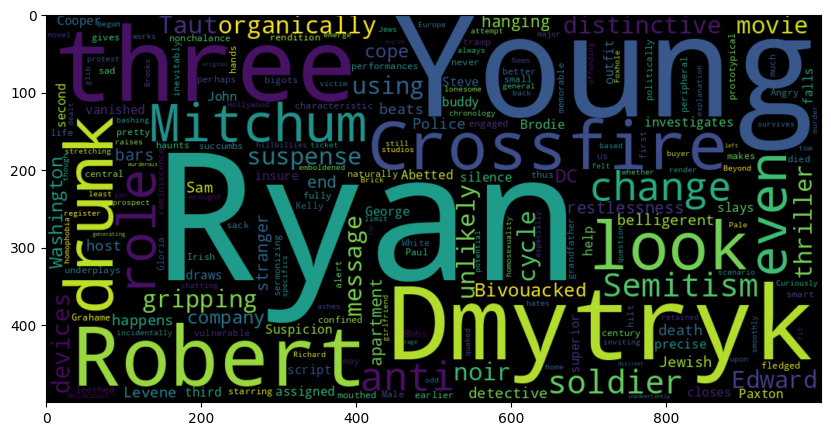

In [ ]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

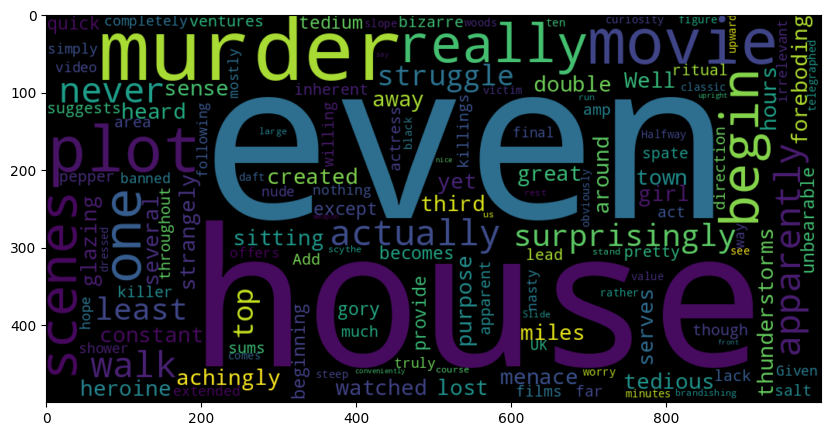

In [ ]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show